In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [4]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [5]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [6]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [7]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [8]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [9]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_train_aug = aug_train_processed[features]
y_train_aug = aug_train_processed[target]

X_test = org_test_processed[features]
y_test = org_test_processed[target]

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
# Define paths

file_name = '../Models/weights'
rf_org_path = f"{file_name}/rf_original_model_V1.pkl"
rf_aug_path = f"{file_name}/rf_augmented_model_V1.pkl"


# Load Random Forest models
rf_org = joblib.load(rf_org_path)

rf_aug = joblib.load(rf_aug_path)


print("Both rf models loaded successfully.")


Both rf models loaded successfully.


In [15]:
# =========================
# Evaluation storage
all_results = []

# Get all unique locations
locations = org_test_processed['Location'].unique()

for loc in locations:
    df_loc = org_test_processed[org_test['Location'] == loc]
    
    # Iterate over months
    for month in range(1, 13):
        df_month = df_loc[df_loc['Timestamp'].dt.month == month]
        
        if df_month.empty:
            continue
        
        X_test = df_month[features]
        y_test = df_month[target]
        
        # Evaluate Original model
        y_pred_org = rf_org.predict(X_test)
        mae_org = mean_absolute_error(y_test, y_pred_org)
        rmse_org = np.sqrt(mean_squared_error(y_test, y_pred_org))
        r2_org = r2_score(y_test, y_pred_org)

        # Evaluate Augmented model
        y_pred_aug = rf_aug.predict(X_test)
        mae_aug = mean_absolute_error(y_test, y_pred_aug)
        rmse_aug = np.sqrt(mean_squared_error(y_test, y_pred_aug))
        r2_aug = r2_score(y_test, y_pred_aug)
        
        # Save results
        all_results.append({
            'Location': loc,
            'Month': month,
            'Model': 'Original',
            'MAE': mae_org,
            'RMSE': rmse_org,
            'R2': r2_org
        })

        all_results.append({
            'Location': loc,
            'Month': month,
            'Model': 'Augmented',
            'MAE': mae_aug,
            'RMSE': rmse_aug,
            'R2': r2_aug
        })
        
        # Save predictions for this location-month
        df_pred = df_month.copy()
        df_pred['Pred_Original'] = y_pred_org
        # df_pred['Pred_Augmented'] = y_pred_aug
        
        # filename = f"monthly_results/{loc}_Month_{month:02d}.csv"
        # df_pred.to_csv(filename, index=False)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_2203/1597280686.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_processed[org_test['Location'] == loc]
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_2203/1597280686.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_processed[org_test['Location'] == loc]
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_2203/1597280686.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_processed[org_test['Location'] == loc]
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_2203/1597280686.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = org_test_processed[org_test['Location'] == loc]


In [16]:
results_df = pd.DataFrame(all_results)

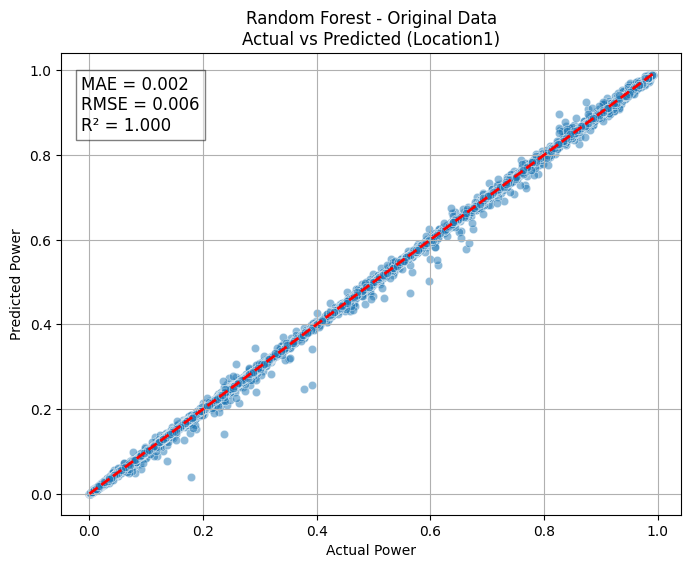

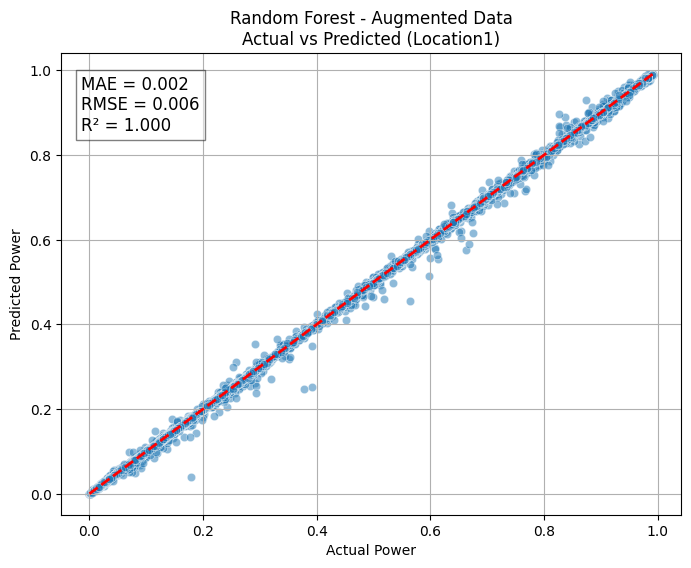

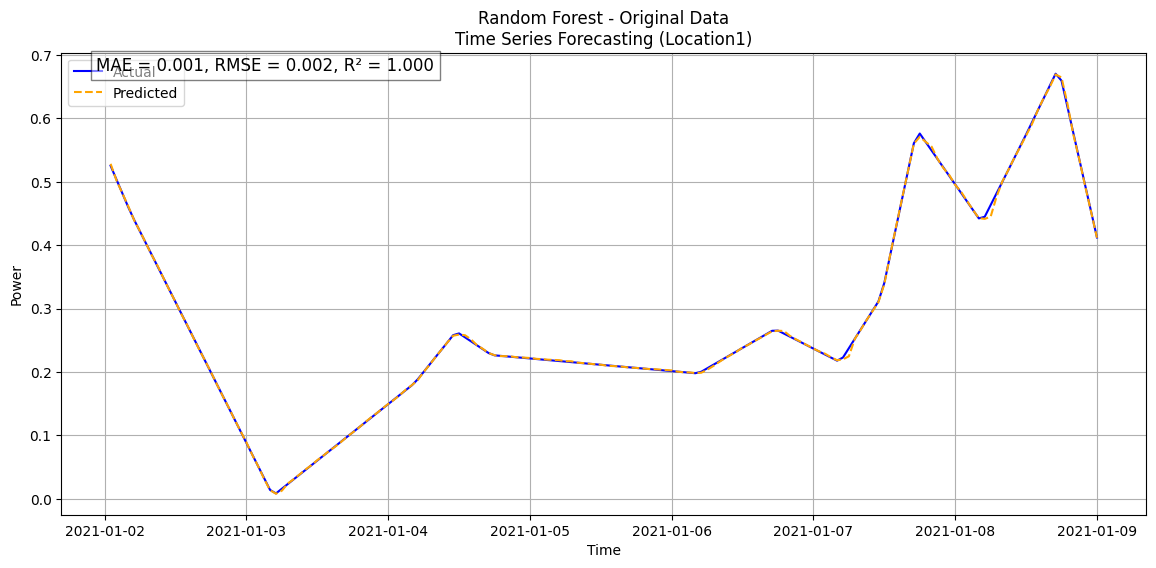

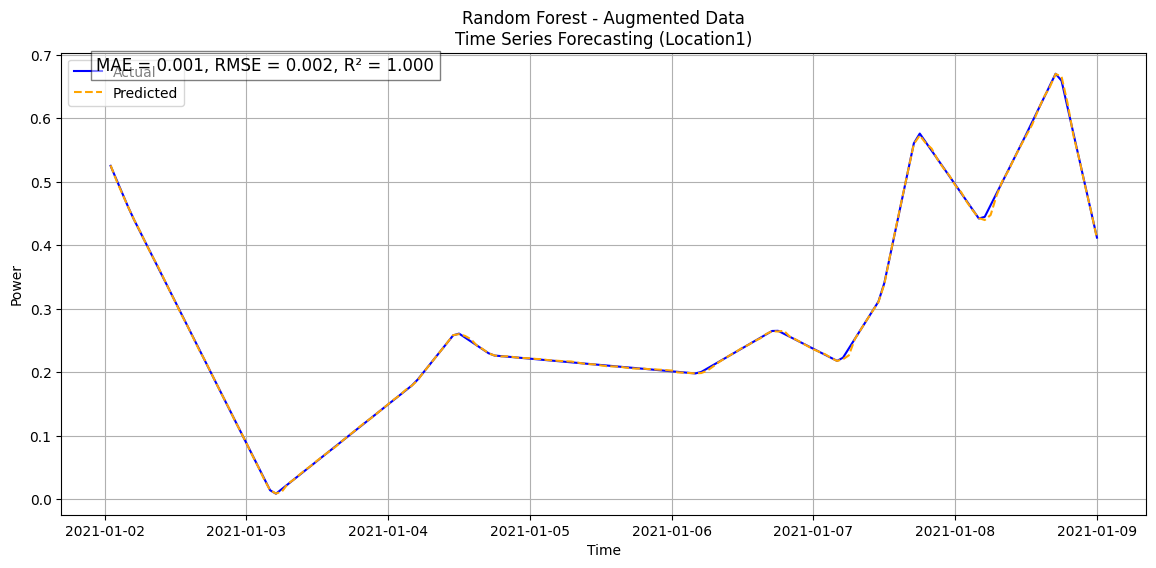

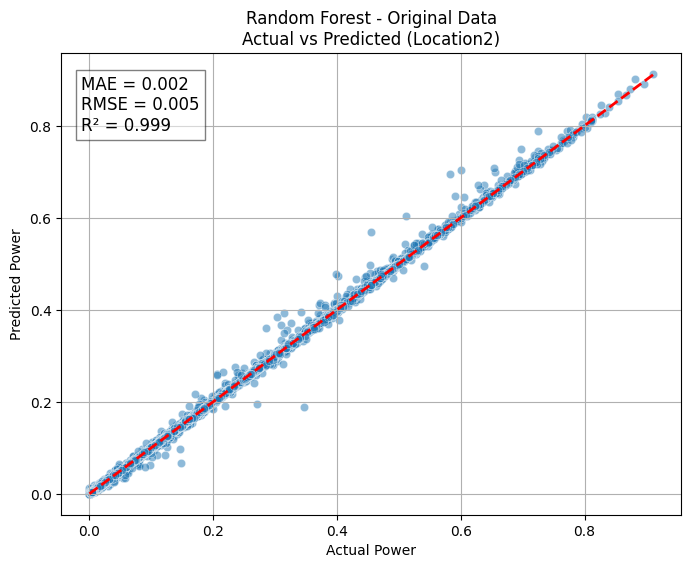

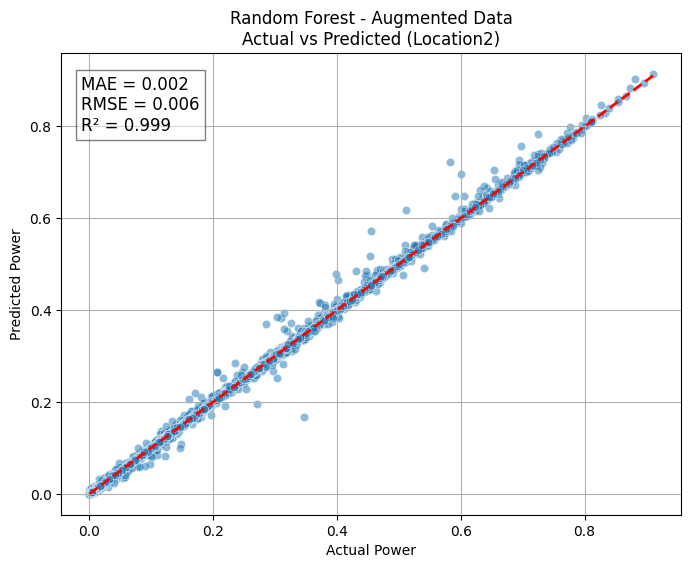

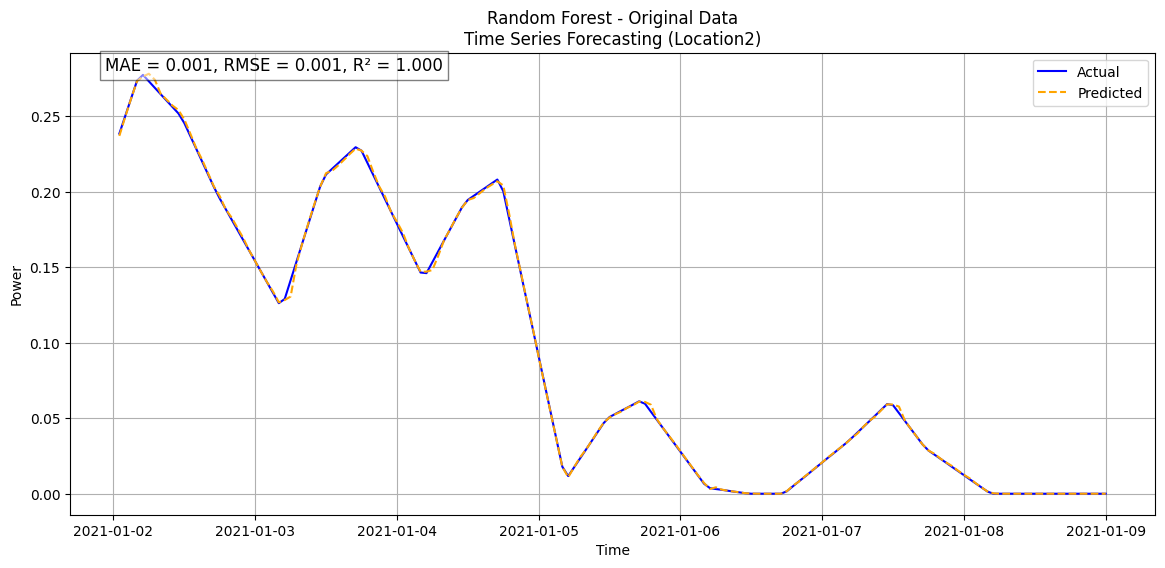

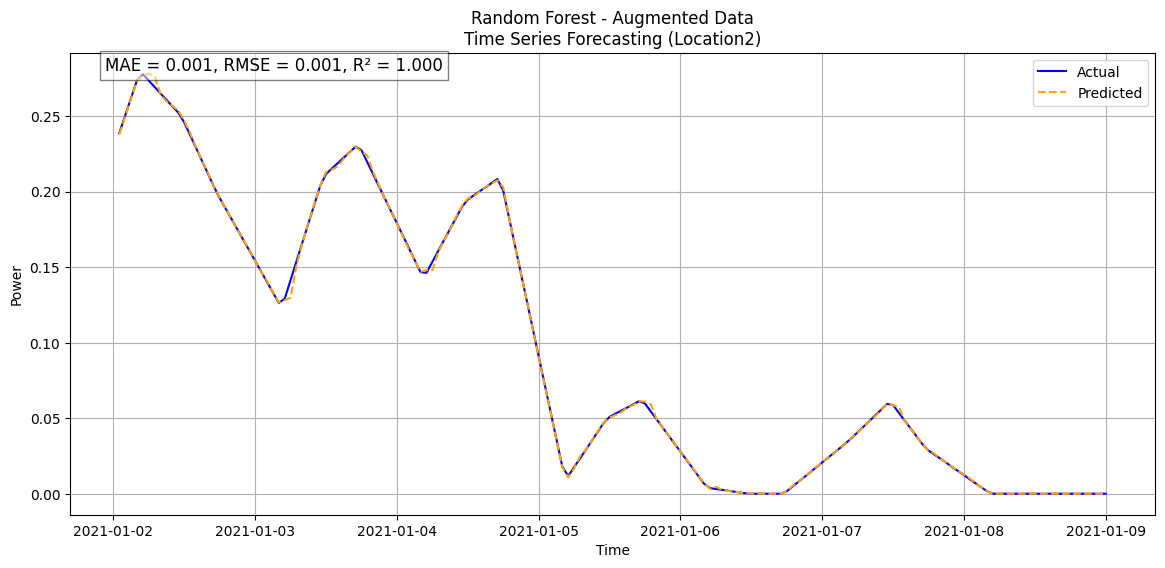

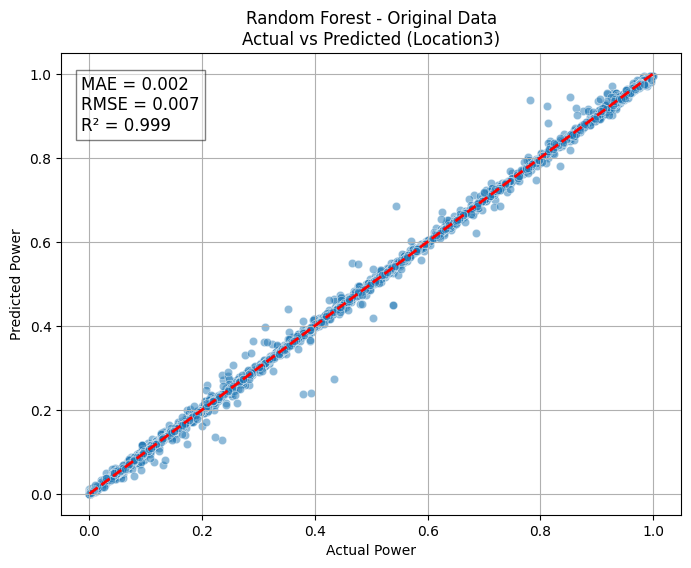

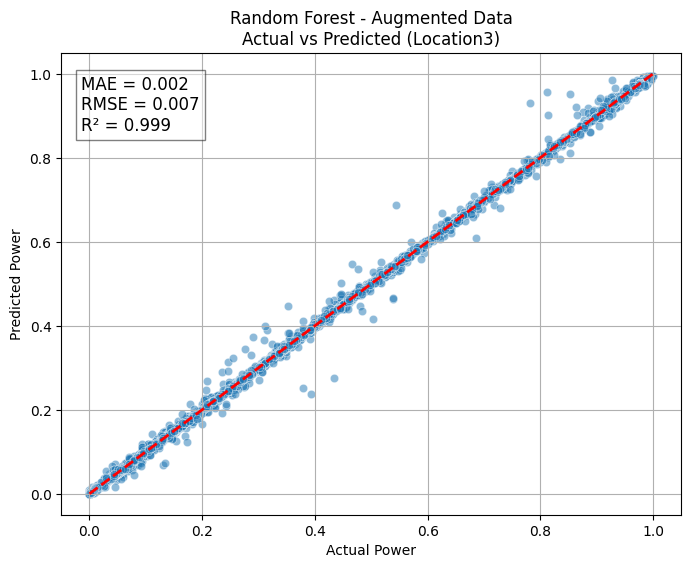

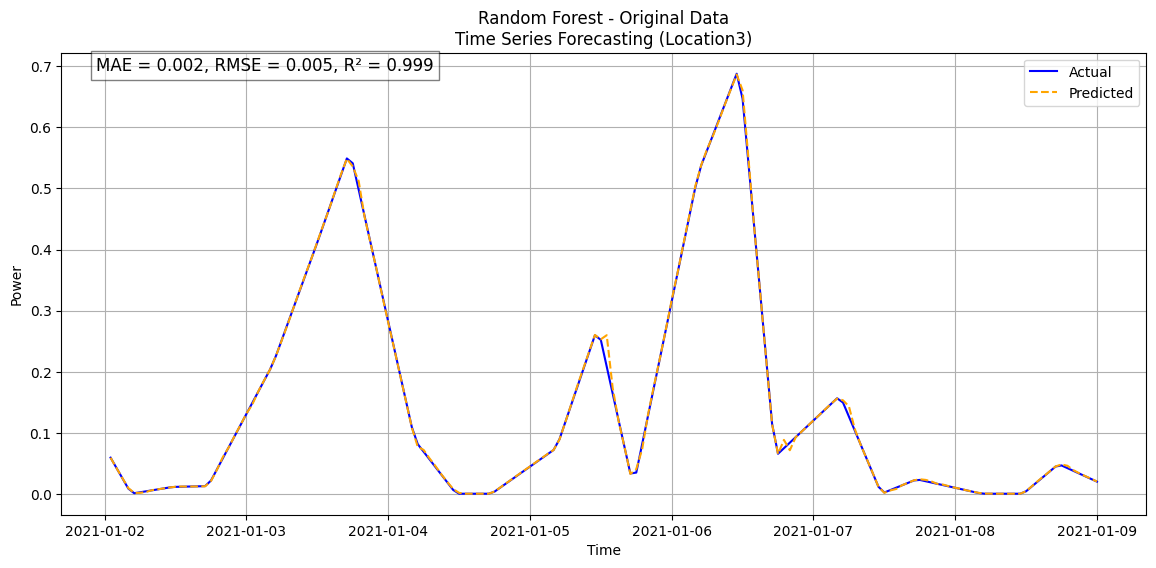

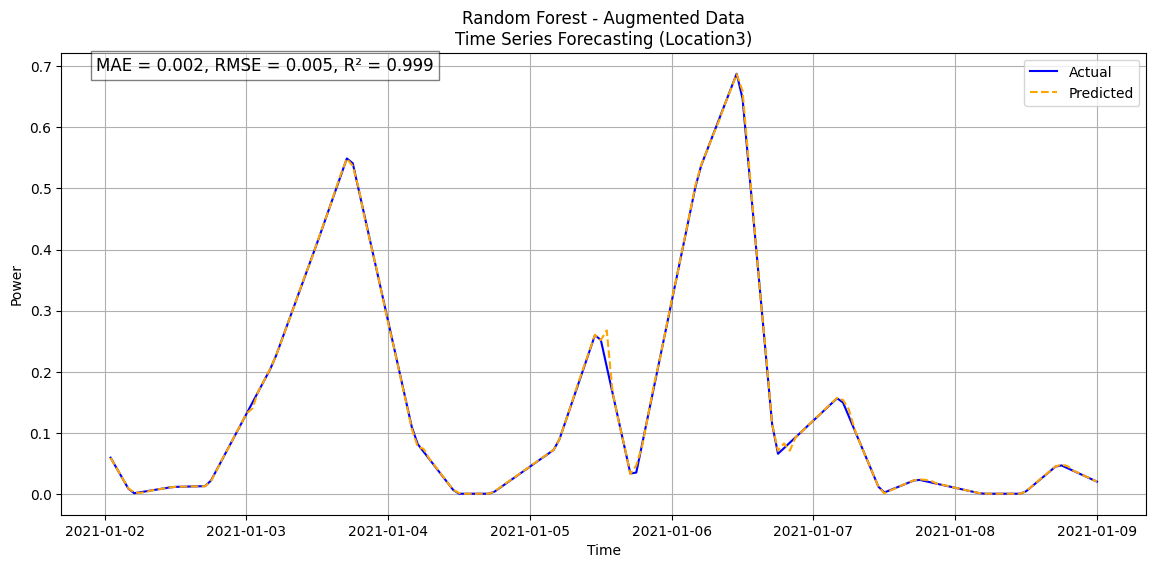

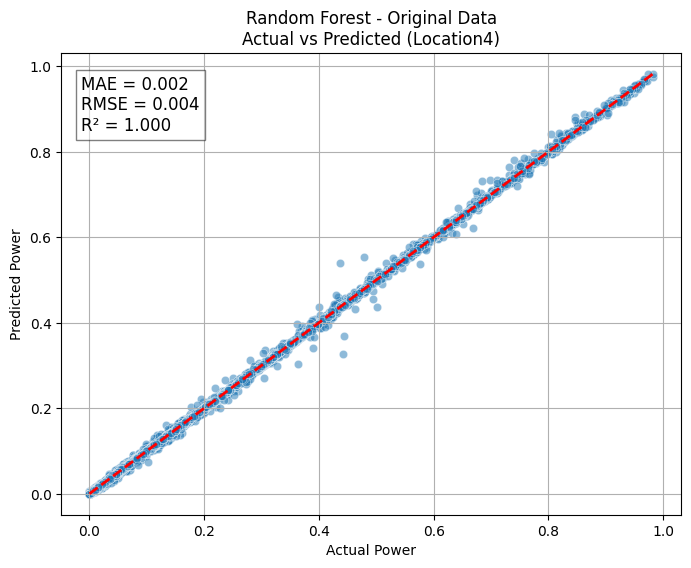

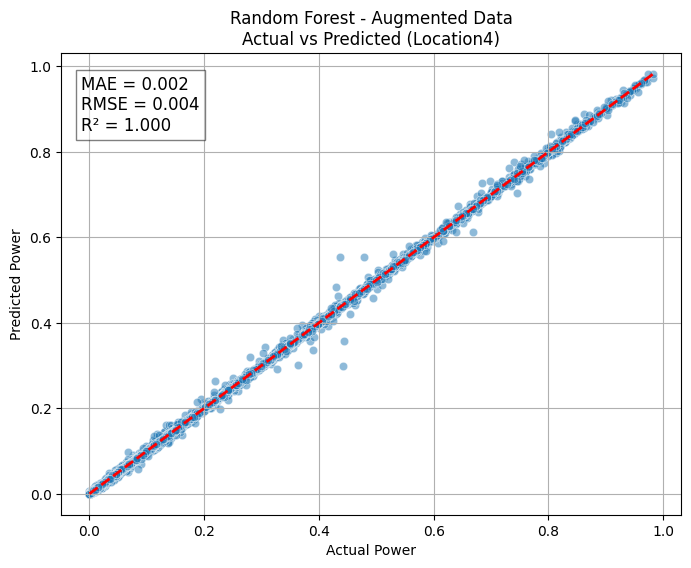

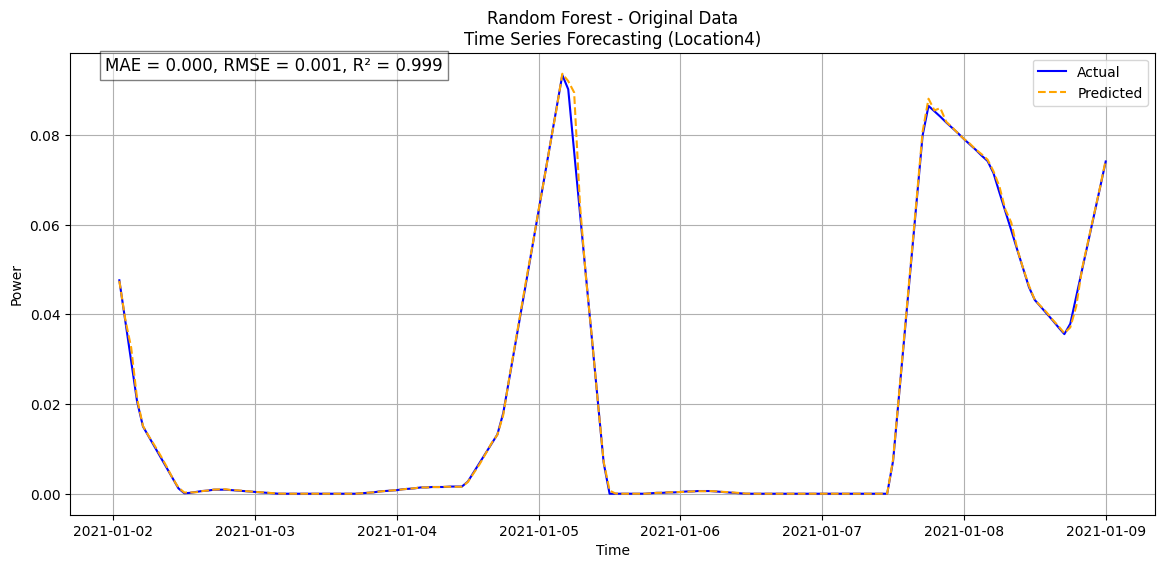

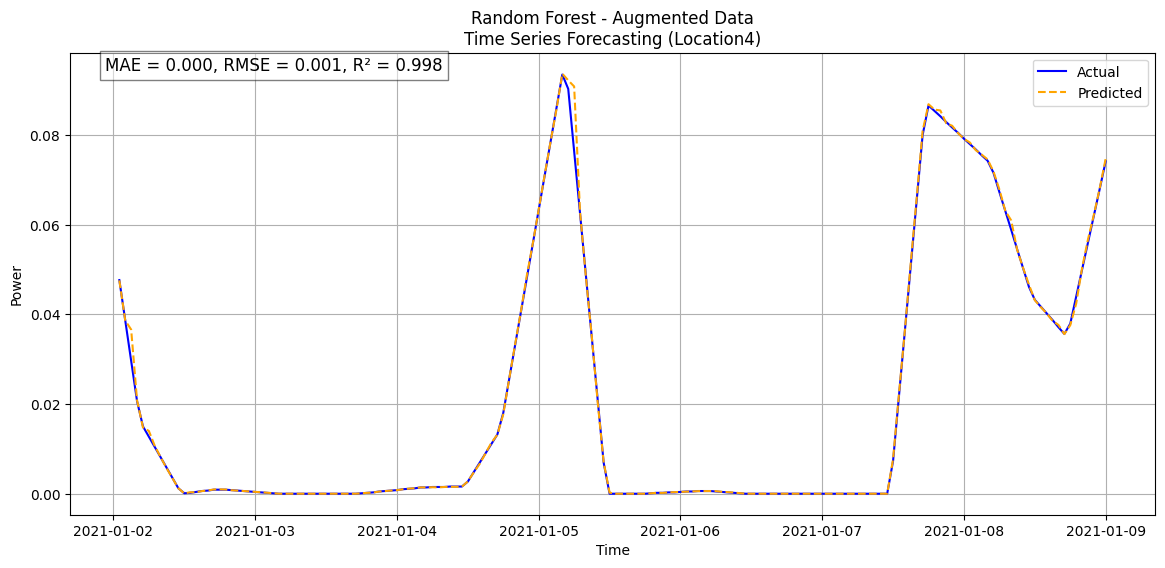

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# =========
# Functions
# =========

def calculate_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_actual_vs_predicted(y_true, y_pred, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Power')
    plt.ylabel('Predicted Power')
    plt.title(f'{model_name} - {dataset_name}\nActual vs Predicted ({location})')
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR² = {r2:.3f}"
    plt.gcf().text(0.15, 0.75, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

def plot_timeseries(y_true, y_pred, timestamps, model_name, dataset_name, location):
    mae, rmse, r2 = calculate_errors(y_true, y_pred)
    
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, y_true, label='Actual', color='blue')
    plt.plot(timestamps, y_pred, label='Predicted', color='orange', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.title(f'{model_name} - {dataset_name}\nTime Series Forecasting ({location})')
    plt.legend()
    plt.grid(True)
    
    textstr = f"MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}"
    plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# =========
# Location-wise visualization
# =========

locations = org_test_processed['Location'].unique()

for loc in locations:
    # Extract data for this location
    loc_mask = org_test_processed['Location'] == loc
    X_test_loc = org_test_processed[features][loc_mask]
    y_test_loc = org_test_processed[target][loc_mask]
    timestamps_loc = org_test_processed['Timestamp'][loc_mask]
    
    # Predictions
    y_pred_org = rf_org.predict(X_test_loc)
    y_pred_aug = rf_aug.predict(X_test_loc)
    
    # Scatter plots
    plot_actual_vs_predicted(y_test_loc, y_pred_org, model_name='Random Forest', dataset_name='Original Data', location=loc)
    plot_actual_vs_predicted(y_test_loc, y_pred_aug, model_name='Random Forest', dataset_name='Augmented Data', location=loc)
    
    # Time series plots (only small subset for clarity)
    subset_size = 7*4*6  # 1 week if data hourly (adjust if needed)
    subset_X = X_test_loc.iloc[:subset_size]
    subset_y = y_test_loc.iloc[:subset_size]
    subset_t = timestamps_loc.iloc[:subset_size]
    
    y_pred_org_subset = rf_org.predict(subset_X)
    y_pred_aug_subset = rf_aug.predict(subset_X)
    
    plot_timeseries(subset_y, y_pred_org_subset, subset_t, model_name='Random Forest', dataset_name='Original Data', location=loc)
    plot_timeseries(subset_y, y_pred_aug_subset, subset_t, model_name='Random Forest', dataset_name='Augmented Data', location=loc)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_dual_forecast_split(timestamps, y_train, y_true, y_pred_org, y_pred_aug,
                              model_name='XGBoost', location='Unknown',
                              conf_int_org=None, conf_int_aug=None):
    """
    Plot actual values with forecasts from original and augmented models, including non-overlapping legend & metrics.
    """
    plt.figure(figsize=(14, 6))
    
    forecast_start_idx = len(y_train)
    full_timestamps = timestamps
    all_actual = np.concatenate([y_train, y_true])
    
    # Training
    plt.plot(full_timestamps[:forecast_start_idx], y_train, color='gray', label='Actual')
    
    # Observed
    plt.plot(full_timestamps[forecast_start_idx:], y_true, color='black', label='Observed')

    # Original Forecast
    plt.plot(full_timestamps[forecast_start_idx:], y_pred_org, color='red', label='Forecast (Original)')
    if conf_int_org:
        lower_o, upper_o = conf_int_org
        plt.fill_between(full_timestamps[forecast_start_idx:], lower_o, upper_o, color='red', alpha=0.2)

    # Augmented Forecast
    plt.plot(full_timestamps[forecast_start_idx:], y_pred_aug, color='blue', linestyle='--', label='Forecast (Augmented)')
    if conf_int_aug:
        lower_a, upper_a = conf_int_aug
        plt.fill_between(full_timestamps[forecast_start_idx:], lower_a, upper_a, color='blue', alpha=0.2)

    # Vertical forecast start line
    plt.axvline(full_timestamps[forecast_start_idx], color='gray', linestyle=':', linewidth=1)

    # Metrics
    mae_org = mean_absolute_error(y_true, y_pred_org)
    rmse_org = np.sqrt(mean_squared_error(y_true, y_pred_org))

    mae_aug = mean_absolute_error(y_true, y_pred_aug)
    rmse_aug = np.sqrt(mean_squared_error(y_true, y_pred_aug))

    # Display metrics bottom-left
    error_text = (
        f"Original:  MAE = {mae_org:.4f}, RMSE = {rmse_org:.4f}\n"
        f"Augmented: MAE = {mae_aug:.4f}, RMSE = {rmse_aug:.4f}"
    )
    plt.gcf().text(0.02, 0.02, error_text, fontsize=11,
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    # Labels and legend
    plt.title(f"{model_name} Forecast Comparison - {location}")
    plt.xlabel("Date")
    plt.ylabel("Power / Demand")
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


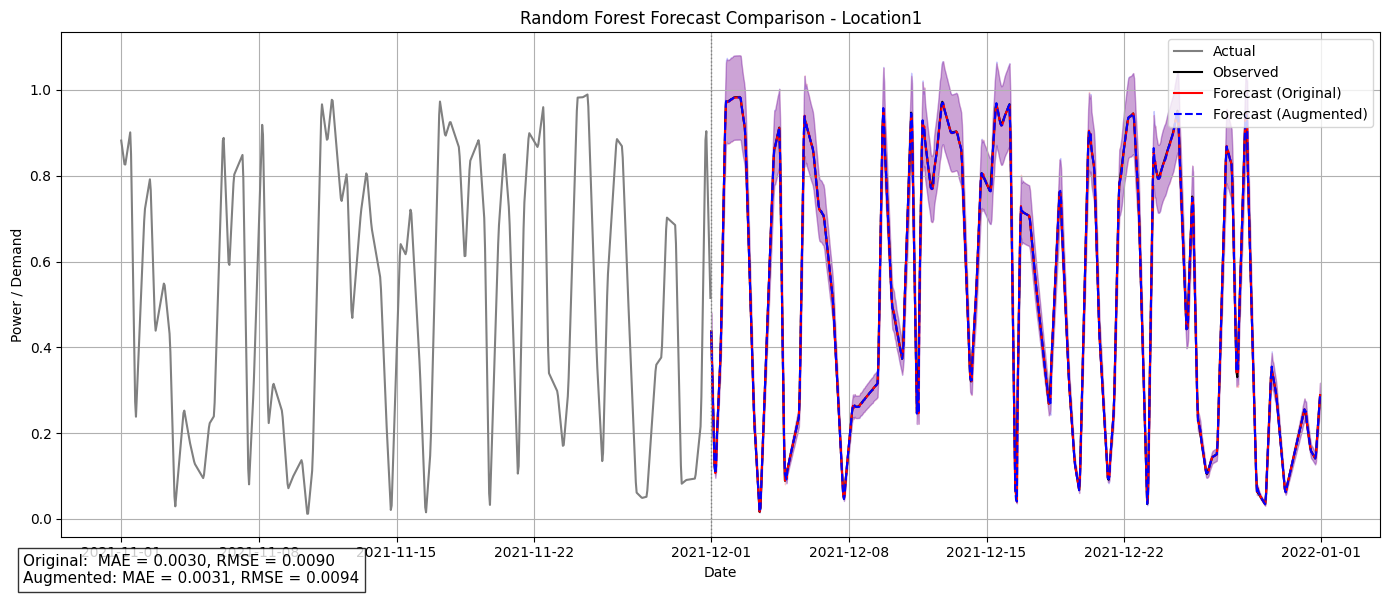

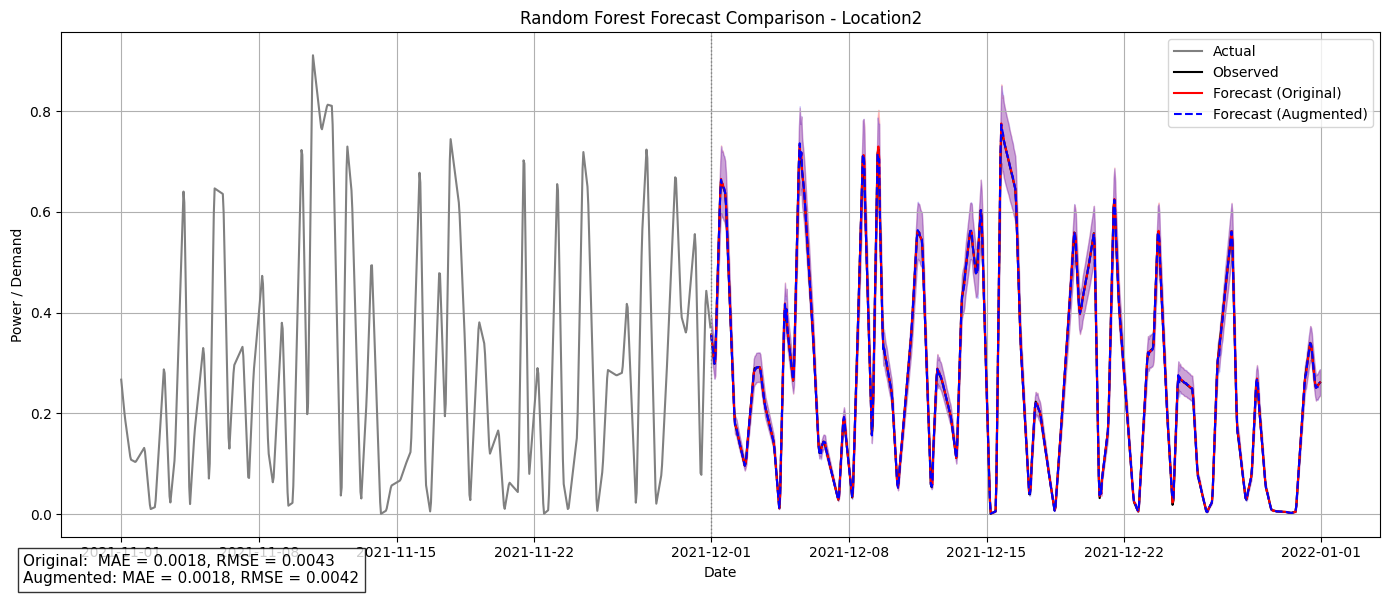

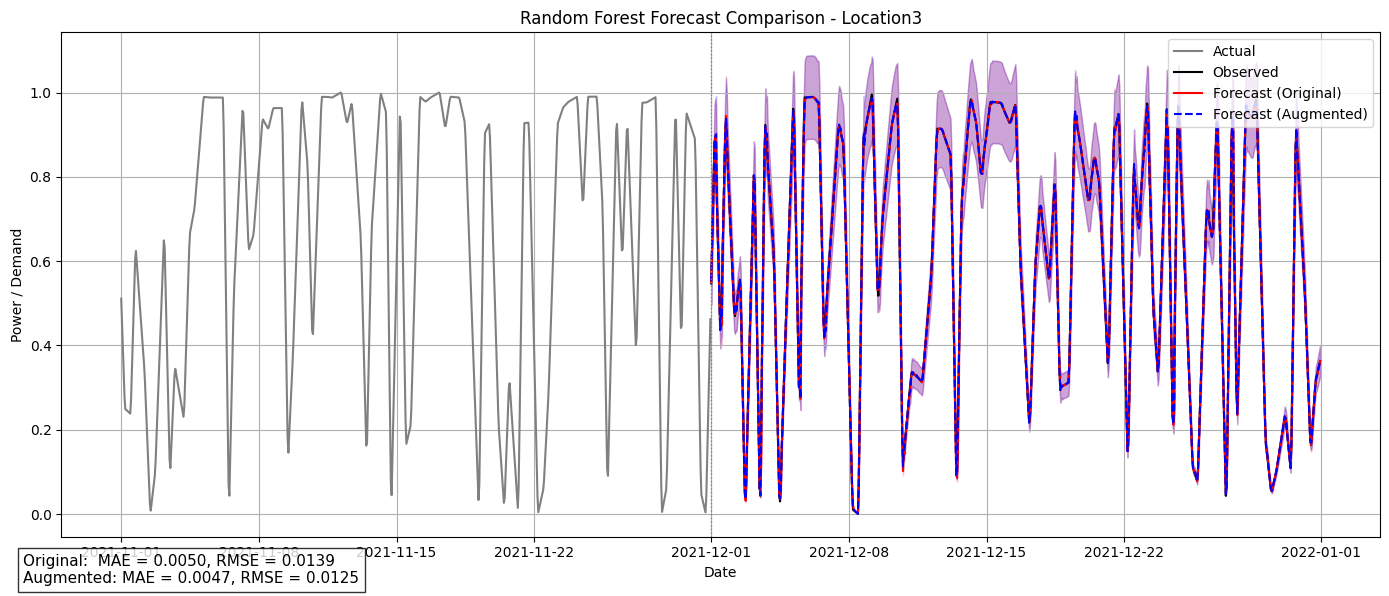

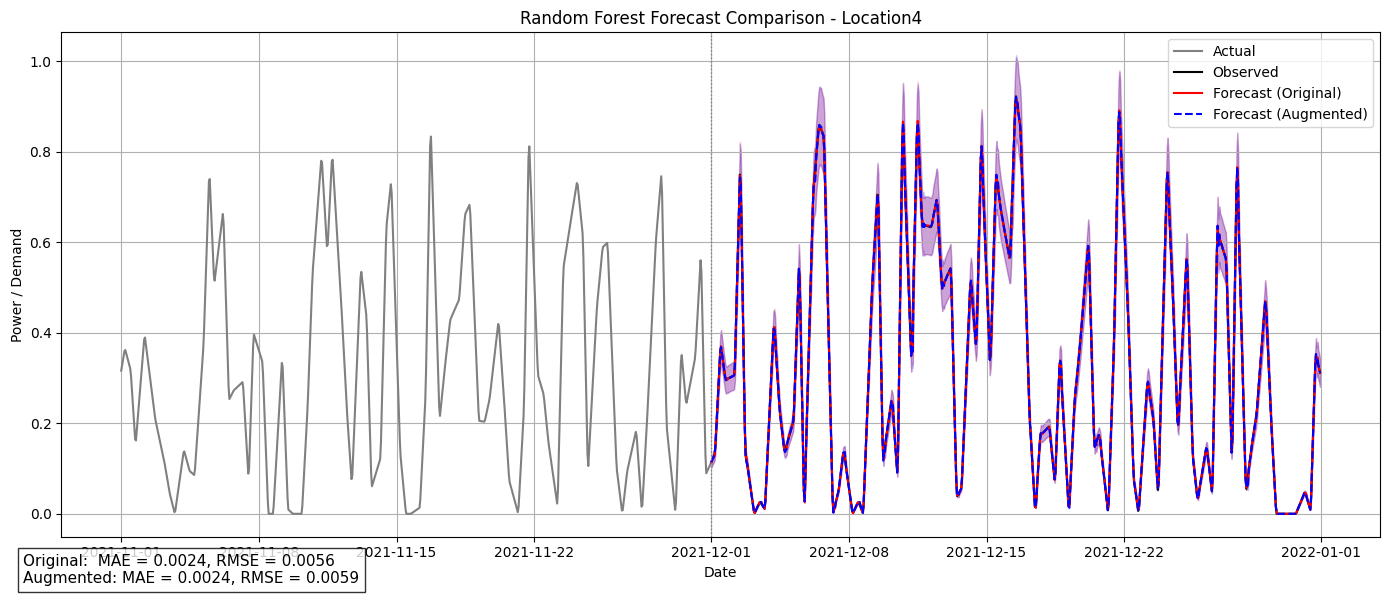

In [21]:
for loc in locations:
    loc_data = org_test_processed[org_test_processed['Location'] == loc].copy()
    loc_data.sort_values('Timestamp', inplace=True)
    loc_data['Timestamp'] = pd.to_datetime(loc_data['Timestamp'])
    loc_data['YearMonth'] = loc_data['Timestamp'].dt.to_period('M')

    # Pick a training month and the next one for forecast
    available_months = sorted(loc_data['YearMonth'].unique())
    
    if len(available_months) < 2:
        continue  # Not enough data to plot

    train_month = available_months[-2]  # e.g., August
    forecast_month = available_months[-1]  # e.g., September

    train_data = loc_data[loc_data['YearMonth'] == train_month]
    forecast_data = loc_data[loc_data['YearMonth'] == forecast_month]

    X_train = train_data[features]
    y_train = train_data[target]

    X_forecast = forecast_data[features]
    y_forecast_true = forecast_data[target]

    # Timestamps
    full_timestamps = np.concatenate([train_data['Timestamp'].values, forecast_data['Timestamp'].values])

    # Forecasts
    y_pred_org = rf_org.predict(X_forecast)
    y_pred_aug = rf_aug.predict(X_forecast)

    # Confidence intervals (dummy)
    ci_org = (y_pred_org * 0.9, y_pred_org * 1.1)
    ci_aug = (y_pred_aug * 0.9, y_pred_aug * 1.1)

    # Plot
    plot_dual_forecast_split(
        timestamps=full_timestamps,
        y_train=y_train,
        y_true=y_forecast_true,
        y_pred_org=y_pred_org,
        y_pred_aug=y_pred_aug,
        model_name='Random Forest',
        location=loc,
        conf_int_org=ci_org,
        conf_int_aug=ci_aug
    )
